In [1]:
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, TrainingArguments, logging
from tqdm import tqdm
logging.set_verbosity_error()
from peft import LoraConfig, PeftConfig, PeftModel
from trl import SFTTrainer
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score
)
import numpy as np
import os
import sys
import gc
milestone_2_path = os.path.abspath("../milestone 2")
sys.path.append(milestone_2_path)

import import_preprocess
from importlib import reload
reload(import_preprocess)

from import_preprocess import ImportPreprocess, convert_labels_to_string, convert_labels_to_int

2025-01-26 14:36:10.743255: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-26 14:36:10.743326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-26 14:36:10.770273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 14:36:10.826097: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-26 14:36:11.754580: W tensorflow/compiler/tf2

# Some initial testing with different Llama models

In [2]:
# # model_id = "meta-llama/Llama-3.2-3B"
# model_id = "meta-llama/Llama-3.2-3B-Instruct"
# tokenizer = AutoTokenizer.from_pretrained(model_id)
#
# # gptq_config = GPTQConfig(
# #     bits=bits,
# #     tokenizer=tokenizer,
# #     use_exllama=False,
# #     use_cuda_fp16=True,
# #     dataset="c4-new"
# # )
#
# model = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     device_map="cuda:0"
# )
#
# model.config.use_cache = False
#
# pipe = pipeline(
#     "text-generation",
#     model=model,
#     tokenizer=tokenizer,
#     # torch_dtype=torch.float16,
#     # device="",
# )
# # quantized_model.save_pretrained(f"test-{model_name}-{bits}bit")

In [3]:
# tokenizer.pad_token_id = tokenizer.eos_token_id
# model.config.use_cache = False
#
# messages = [{"role": "user", "content": "Tell me something unexpected about austria"}]
#
# prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
# # outputs = pipe(prompt, max_new_tokens=120, do_sample=True, temperature=0.7)
# outputs = pipe(prompt, max_new_tokens=1000)#, temperature=1.0)
# print(outputs[0]["generated_text"])

# Load data

In [2]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()
import_preprocess.create_balanced_dataset(n_samples=7000)

_, y_train, S_train, y_train_multi = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train, import_preprocess.y_train_multi
_, y_val, S_val, y_val_multi = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val, import_preprocess.y_val_multi
_, y_test, S_test, y_test_multi = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test, import_preprocess.y_test_multi
_, y_balanced, S_balanced, y_balanced_multi = import_preprocess.X_train_balanced, import_preprocess.y_train_balanced, import_preprocess.S_train_balanced, import_preprocess.y_train_multi_balanced

print("Number of training samples:", len(y_train))
print("Number of validation samples:", len(y_val))
print("Number of test samples:", len(y_test))
print("Number of balanced samples:", len(y_balanced))

train_df = pd.DataFrame({"comment": S_train, "label": y_train, "multi_label": y_train_multi})
val_df = pd.DataFrame({"comment": S_val, "label": y_val, "multi_label": y_val_multi})
test_df = pd.DataFrame({"comment": S_test, "label": y_test, "multi_label": y_test_multi})
balanced_df = pd.DataFrame({"comment": S_balanced, "label": y_balanced, "multi_label": y_balanced_multi})

def generate_prompt(entry):
    return f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: {entry["comment"]}
label: {entry["label"]}
""".strip()

def generate_test_prompt(entry):
    return f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: {entry["comment"]}
label:
""".strip()

train_df["text"] = train_df.apply(generate_prompt, axis=1)
val_df["text"] = val_df.apply(generate_prompt, axis=1)
balanced_df["text"] = balanced_df.apply(generate_prompt, axis=1)
test_df["text"] = test_df.apply(generate_test_prompt, axis=1)

train_data = Dataset.from_pandas(train_df)
val_data = Dataset.from_pandas(val_df)
balanced_data = Dataset.from_pandas(balanced_df)
test_data = Dataset.from_pandas(test_df)

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 14000


# Evaluate model without fine-tuning

In [3]:
def clear_memory():
    try:
        global model
        global tokenizer
        del model, tokenizer
    except NameError:
        pass
    finally:
        gc.collect()
        torch.cuda.empty_cache()

In [35]:
clear_memory()

model_id = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0"
)

model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
def predict(test_data, model, tokenizer, categories, temperature=0.01):
    y_pred = []
    categories = categories

    for i in tqdm(range(len(test_data))):
        prompt = test_data[i]["text"]

        pipe = pipeline(
            task="text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=2,
            temperature=temperature
        )
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("label:")[-1].strip()

        for category in categories:
            if category == answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")

    return y_pred


def evaluate(y_true, y_pred):
    labels = ["not sexist", "sexist", "none"]
    mapping = {label: idx for idx, label in enumerate(labels)}

    def map_func(x):
        return mapping.get(x, -1)

    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)

    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')

    balanced_accuracy = balanced_accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Balanced Accuracy: {balanced_accuracy:.3f}')

    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))), zero_division=0, digits=3)
    print('\nClassification Report:')
    print(class_report)

    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

In [46]:
val_df["text"] = val_df.apply(generate_test_prompt, axis=1)
val_data = Dataset.from_pandas(val_df)

y_pred = predict(val_data, model, tokenizer, ["not sexist", "sexist"])
evaluate(y_val, y_pred)

val_df["text"] = val_df.apply(generate_prompt, axis=1)
val_data = Dataset.from_pandas(val_df)

100%|██████████| 2000/2000 [01:34<00:00, 21.15it/s]

Accuracy: 0.585
Balanced Accuracy: 0.666

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.904     0.507     0.650      1514
      sexist      0.351     0.825     0.493       486
        none      0.000     0.000     0.000         0

    accuracy                          0.585      2000
   macro avg      0.418     0.444     0.381      2000
weighted avg      0.769     0.585     0.612      2000


Confusion Matrix:
[[768 740   6]
 [ 82 401   3]
 [  0   0   0]]



/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


# Define functions for fine-tuning

In [5]:
def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


def fine_tune(model, tokenizer, train_dataset, eval_dataset, fine_tuned_dir, new_model_dir, epochs):
    modules = find_all_linear_names(model)

    peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0,
        r=64,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=modules,
    )

    training_arguments = TrainingArguments(
        output_dir=fine_tuned_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=8,
        gradient_checkpointing=True,
        optim="paged_adamw_32bit",
        logging_steps=1,
        learning_rate=2e-4,
        weight_decay=0.001,
        fp16=True,
        bf16=False,
        max_grad_norm=0.3,
        max_steps=-1,
        warmup_ratio=0.03,
        group_by_length=False,
        lr_scheduler_type="cosine",
        evaluation_strategy="epoch",
        report_to=["tensorboard"],
        save_strategy="epoch",
    )

    trainer = SFTTrainer(
        model=model,
        args=training_arguments,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        peft_config=peft_config,
        tokenizer=tokenizer,
    )

    trainer.train()

    trainer.save_model(fine_tuned_dir)
    tokenizer.save_pretrained(fine_tuned_dir)

    model = PeftModel.from_pretrained(model, fine_tuned_dir)
    model = model.merge_and_unload()

    model.save_pretrained(new_model_dir)
    tokenizer.save_pretrained(new_model_dir)

    del trainer

    return model, tokenizer

# Fine-tune model on train set

In [14]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"
output_dir_base = "../milestone3/llama-3.2-fine-tuned-train"
new_model_dir_base = "../milestone3/Llama-3.2-3B-Instruct-Sexism-Classification-Train"

epochs = 5
clear_memory()
output_dir = f"{output_dir_base}-{epochs}"
new_model_dir = f"{new_model_dir_base}-{epochs}"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0"
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

model, tokenizer = fine_tune(model, tokenizer, train_data, val_data, output_dir, new_model_dir, epochs)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_125812/1456593974.py:35: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'loss': 34.2936, 'grad_norm': 6.121873378753662, 'learning_rate': 7.604562737642586e-07, 'epoch': 0.0005714285714285715}
{'loss': 31.8518, 'grad_norm': 6.1572699546813965, 'learning_rate': 1.5209125475285172e-06, 'epoch': 0.001142857142857143}
{'loss': 31.3012, 'grad_norm': 5.501338481903076, 'learning_rate': 2.281368821292776e-06, 'epoch': 0.0017142857142857142}
{'loss': 33.1582, 'grad_norm': 5.4560675621032715, 'learning_rate': 3.0418250950570345e-06, 'epoch': 0.002285714285714286}
{'loss': 32.4936, 'grad_norm': 5.463005542755127, 'learning_rate': 3.8022813688212926e-06, 'epoch': 0.002857142857142857}
{'loss': 31.2595, 'grad_norm': 5.612952709197998, 'learning_rate': 4.562737642585552e-06, 'epoch': 0.0034285714285714284}
{'loss': 31.0172, 'grad_norm': 5.250010013580322, 'learning_rate': 5.32319391634981e-06, 'epoch': 0.004}
{'loss': 32.5899, 'grad_norm': 6.2719011306762695, 'learning_rate': 6.083650190114069e-06, 'epoch': 0.004571428571428572}
{'loss': 33.9541, 'grad_norm': 5.511097

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 04996b8c-8d0e-4eee-91f4-984437bacea2)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 14.9567, 'grad_norm': 2.03979229927063, 'learning_rate': 0.00018522966761235472, 'epoch': 1.0005714285714287}
{'loss': 14.3832, 'grad_norm': 2.0355513095855713, 'learning_rate': 0.0001852102999580612, 'epoch': 1.0011428571428571}
{'loss': 13.3768, 'grad_norm': 2.0213863849639893, 'learning_rate': 0.0001851909206280542, 'epoch': 1.0017142857142858}
{'loss': 13.5212, 'grad_norm': 1.8584526777267456, 'learning_rate': 0.00018517152962498908, 'epoch': 1.0022857142857142}
{'loss': 13.8551, 'grad_norm': 1.9313554763793945, 'learning_rate': 0.00018515212695152284, 'epoch': 1.002857142857143}
{'loss': 13.5005, 'grad_norm': 2.035161256790161, 'learning_rate': 0.00018513271261031406, 'epoch': 1.0034285714285713}
{'loss': 14.4132, 'grad_norm': 1.9953370094299316, 'learning_rate': 0.000185113286604023, 'epoch': 1.004}
{'loss': 15.616, 'grad_norm': 2.157604217529297, 'learning_rate': 0.0001850938489353114, 'epoch': 1.0045714285714287}
{'loss': 13.4786, 'grad_norm': 2.5143797397613525, 'lear

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: f5aae07f-880c-45a8-be03-53d60edad545)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 6.8287, 'grad_norm': 3.8440186977386475, 'learning_rate': 7.289559207374341e-05, 'epoch': 3.0005714285714284}
{'loss': 8.3401, 'grad_norm': 3.9765403270721436, 'learning_rate': 7.285996304643966e-05, 'epoch': 3.0011428571428573}
{'loss': 7.3541, 'grad_norm': 3.7812671661376953, 'learning_rate': 7.282433773792689e-05, 'epoch': 3.001714285714286}
{'loss': 5.9912, 'grad_norm': 3.7889418601989746, 'learning_rate': 7.27887161530866e-05, 'epoch': 3.0022857142857142}
{'loss': 8.4675, 'grad_norm': 4.0169172286987305, 'learning_rate': 7.275309829679972e-05, 'epoch': 3.0028571428571427}
{'loss': 8.161, 'grad_norm': 4.225139617919922, 'learning_rate': 7.271748417394668e-05, 'epoch': 3.0034285714285716}
{'loss': 6.4408, 'grad_norm': 3.9978106021881104, 'learning_rate': 7.268187378940742e-05, 'epoch': 3.004}
{'loss': 7.1648, 'grad_norm': 4.506690979003906, 'learning_rate': 7.264626714806134e-05, 'epoch': 3.0045714285714284}
{'loss': 9.4666, 'grad_norm': 4.995579242706299, 'learning_rate': 

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 11602709-1f5e-4d31-8671-e11f05321db6)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'eval_loss': 2.4403889179229736, 'eval_runtime': 17.8905, 'eval_samples_per_second': 111.791, 'eval_steps_per_second': 13.974, 'epoch': 5.0}
{'train_runtime': 13898.9988, 'train_samples_per_second': 5.036, 'train_steps_per_second': 0.63, 'train_loss': 10.256376841790335, 'epoch': 5.0}


# Fine-tune model on balanced data set

In [16]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"
output_dir_base = "llama-3.2-fine-tuned-balanced"
new_model_dir_base = "Llama-3.2-3B-Instruct-Sexism-Classification-Balanced"

epochs = 5
clear_memory()
output_dir = f"{output_dir_base}-{epochs}"
new_model_dir = f"{new_model_dir_base}-{epochs}"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0"
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

model, tokenizer = fine_tune(model, tokenizer, balanced_data, val_data, output_dir, new_model_dir, epochs)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_125812/1456593974.py:35: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'loss': 33.7364, 'grad_norm': 5.553005695343018, 'learning_rate': 7.604562737642586e-07, 'epoch': 0.0005714285714285715}
{'loss': 29.6569, 'grad_norm': 5.273013591766357, 'learning_rate': 1.5209125475285172e-06, 'epoch': 0.001142857142857143}
{'loss': 31.4294, 'grad_norm': 4.863887786865234, 'learning_rate': 2.281368821292776e-06, 'epoch': 0.0017142857142857142}
{'loss': 34.1867, 'grad_norm': 5.379356861114502, 'learning_rate': 3.0418250950570345e-06, 'epoch': 0.002285714285714286}
{'loss': 31.4971, 'grad_norm': 4.774855613708496, 'learning_rate': 3.8022813688212926e-06, 'epoch': 0.002857142857142857}
{'loss': 33.8748, 'grad_norm': 5.425099849700928, 'learning_rate': 4.562737642585552e-06, 'epoch': 0.0034285714285714284}
{'loss': 31.2398, 'grad_norm': inf, 'learning_rate': 4.562737642585552e-06, 'epoch': 0.004}
{'loss': 32.2981, 'grad_norm': 5.811557292938232, 'learning_rate': 5.32319391634981e-06, 'epoch': 0.004571428571428572}
{'loss': 32.9443, 'grad_norm': 5.762794494628906, 'learn

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 2045f9c3-ad53-45e5-a747-14621b4ccaa8)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 11.8531, 'grad_norm': 3.467794179916382, 'learning_rate': 0.00018524902358828092, 'epoch': 1.0005714285714287}
{'loss': 10.9681, 'grad_norm': 3.1148416996002197, 'learning_rate': 0.00018522966761235472, 'epoch': 1.0011428571428571}
{'loss': 9.0667, 'grad_norm': 3.379246711730957, 'learning_rate': 0.0001852102999580612, 'epoch': 1.0017142857142858}
{'loss': 13.8536, 'grad_norm': 3.386082410812378, 'learning_rate': 0.0001851909206280542, 'epoch': 1.0022857142857142}
{'loss': 9.9932, 'grad_norm': 3.2984750270843506, 'learning_rate': 0.00018517152962498908, 'epoch': 1.002857142857143}
{'loss': 9.7782, 'grad_norm': 3.6475186347961426, 'learning_rate': 0.00018515212695152284, 'epoch': 1.0034285714285713}
{'loss': 9.6254, 'grad_norm': 3.6143994331359863, 'learning_rate': 0.00018513271261031406, 'epoch': 1.004}
{'loss': 8.4963, 'grad_norm': 4.525665283203125, 'learning_rate': 0.000185113286604023, 'epoch': 1.0045714285714287}
{'loss': 10.4737, 'grad_norm': 3.9661736488342285, 'learnin

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: fbb09617-a48b-4598-b9fd-c76b9a5a37b1)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 4.8921, 'grad_norm': 4.5409369468688965, 'learning_rate': 7.289559207374341e-05, 'epoch': 3.0005714285714284}
{'loss': 5.1291, 'grad_norm': 4.554352283477783, 'learning_rate': 7.285996304643966e-05, 'epoch': 3.0011428571428573}
{'loss': 3.0866, 'grad_norm': 3.8398969173431396, 'learning_rate': 7.282433773792689e-05, 'epoch': 3.001714285714286}
{'loss': 5.6652, 'grad_norm': 5.9932169914245605, 'learning_rate': 7.27887161530866e-05, 'epoch': 3.0022857142857142}
{'loss': 2.435, 'grad_norm': 3.103386640548706, 'learning_rate': 7.275309829679972e-05, 'epoch': 3.0028571428571427}
{'loss': 4.9614, 'grad_norm': 5.519444465637207, 'learning_rate': 7.271748417394668e-05, 'epoch': 3.0034285714285716}
{'loss': 5.0821, 'grad_norm': 4.780813694000244, 'learning_rate': 7.268187378940742e-05, 'epoch': 3.004}
{'loss': 1.4436, 'grad_norm': 1.6037747859954834, 'learning_rate': 7.264626714806134e-05, 'epoch': 3.0045714285714284}
{'loss': 5.3836, 'grad_norm': 5.980447769165039, 'learning_rate': 7.

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: e5462a2e-8d55-49be-b4de-5be0ffcaf4aa)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'eval_loss': 2.6274545192718506, 'eval_runtime': 17.9138, 'eval_samples_per_second': 111.646, 'eval_steps_per_second': 13.956, 'epoch': 5.0}
{'train_runtime': 12869.3921, 'train_samples_per_second': 5.439, 'train_steps_per_second': 0.68, 'train_loss': 7.4573593334198, 'epoch': 5.0}


# Benchmarking models

## Benchmarking model fine-tuned on train set

In [6]:
val_df["text"] = val_df.apply(generate_test_prompt, axis=1)
val_data = Dataset.from_pandas(val_df)

clear_memory()

model_id = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0"
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

fine_tuned_dir = "../milestone3/llama-3.2-fine-tuned-train-5"

for i in range(1, 6):
    checkpoint_dir = f"{fine_tuned_dir}/checkpoint-{i*1750}"
    model = PeftModel.from_pretrained(model, checkpoint_dir)
    model = model.merge_and_unload()

    y_pred = predict(val_data, model, tokenizer, ["not sexist", "sexist"])
    print(f"\n ------------------ Checkpoint {i} ------------------ ")
    evaluate(y_val, y_pred)
    print(" ----------------------------------------------------- \n")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [01:35<00:00, 20.92it/s]



 ------------------ Checkpoint 1 ------------------ 
Accuracy: 0.883
Balanced Accuracy: 0.860

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.938     0.906     0.922      1514
      sexist      0.735     0.815     0.773       486
        none      0.000     0.000     0.000         0

    accuracy                          0.883      2000
   macro avg      0.558     0.573     0.565      2000
weighted avg      0.889     0.883     0.885      2000


Confusion Matrix:
[[1371  143    0]
 [  90  396    0]
 [   0    0    0]]
 ----------------------------------------------------- 



100%|██████████| 2000/2000 [01:36<00:00, 20.72it/s]
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 ------------------ Checkpoint 2 ------------------ 
Accuracy: 0.867
Balanced Accuracy: 0.821

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.914     0.910     0.912      1514
      sexist      0.793     0.733     0.761       486
        none      0.000     0.000     0.000         0

    accuracy                          0.867      2000
   macro avg      0.569     0.547     0.558      2000
weighted avg      0.885     0.867     0.875      2000


Confusion Matrix:
[[1377   93   44]
 [ 129  356    1]
 [   0    0    0]]
 ----------------------------------------------------- 



100%|██████████| 2000/2000 [01:42<00:00, 19.46it/s]
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 ------------------ Checkpoint 3 ------------------ 
Accuracy: 0.353
Balanced Accuracy: 0.391

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.870     0.318     0.465      1514
      sexist      0.787     0.465     0.585       486
        none      0.000     0.000     0.000         0

    accuracy                          0.353      2000
   macro avg      0.552     0.261     0.350      2000
weighted avg      0.850     0.353     0.494      2000


Confusion Matrix:
[[481  61 972]
 [ 72 226 188]
 [  0   0   0]]
 ----------------------------------------------------- 



100%|██████████| 2000/2000 [01:40<00:00, 19.89it/s]
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 ------------------ Checkpoint 4 ------------------ 
Accuracy: 0.004
Balanced Accuracy: 0.007

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.667     0.001     0.003      1514
      sexist      0.857     0.012     0.024       486
        none      0.000     0.000     0.000         0

    accuracy                          0.004      2000
   macro avg      0.508     0.005     0.009      2000
weighted avg      0.713     0.004     0.008      2000


Confusion Matrix:
[[   2    1 1511]
 [   1    6  479]
 [   0    0    0]]
 ----------------------------------------------------- 



100%|██████████| 2000/2000 [01:38<00:00, 20.21it/s]


 ------------------ Checkpoint 5 ------------------ 
Accuracy: 0.000
Balanced Accuracy: 0.000

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.000     0.000     0.000    1514.0
      sexist      0.000     0.000     0.000     486.0
        none      0.000     0.000     0.000       0.0

    accuracy                          0.000    2000.0
   macro avg      0.000     0.000     0.000    2000.0
weighted avg      0.000     0.000     0.000    2000.0


Confusion Matrix:
[[   0    0 1514]
 [   0    0  486]
 [   0    0    0]]
 ----------------------------------------------------- 




/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


## Benchmarking model fine-tuned on balanced set

In [7]:
val_df["text"] = val_df.apply(generate_test_prompt, axis=1)
val_data = Dataset.from_pandas(val_df)

clear_memory()

model_id = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0"
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

fine_tuned_dir = "../milestone3/llama-3.2-fine-tuned-balanced-5"

for i in range(1, 6):
    checkpoint_dir = f"{fine_tuned_dir}/checkpoint-{i*1750}"
    model = PeftModel.from_pretrained(model, checkpoint_dir)
    model = model.merge_and_unload()

    y_pred = predict(val_data, model, tokenizer, ["not sexist", "sexist"])
    print(f"\n ------------------ Checkpoint {i} ------------------ ")
    evaluate(y_val, y_pred)
    print(" ----------------------------------------------------- \n")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [01:37<00:00, 20.44it/s]



 ------------------ Checkpoint 1 ------------------ 
Accuracy: 0.884
Balanced Accuracy: 0.808

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.897     0.957     0.926      1514
      sexist      0.831     0.658     0.735       486
        none      0.000     0.000     0.000         0

    accuracy                          0.884      2000
   macro avg      0.576     0.539     0.554      2000
weighted avg      0.881     0.884     0.880      2000


Confusion Matrix:
[[1449   65    0]
 [ 166  320    0]
 [   0    0    0]]
 ----------------------------------------------------- 



100%|██████████| 2000/2000 [01:38<00:00, 20.34it/s]
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 ------------------ Checkpoint 2 ------------------ 
Accuracy: 0.842
Balanced Accuracy: 0.693

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.838     0.982     0.904      1514
      sexist      0.947     0.405     0.568       486
        none      0.000     0.000     0.000         0

    accuracy                          0.842      2000
   macro avg      0.595     0.462     0.491      2000
weighted avg      0.865     0.842     0.822      2000


Confusion Matrix:
[[1486   11   17]
 [ 287  197    2]
 [   0    0    0]]
 ----------------------------------------------------- 



100%|██████████| 2000/2000 [01:41<00:00, 19.72it/s]
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 ------------------ Checkpoint 3 ------------------ 
Accuracy: 0.011
Balanced Accuracy: 0.016

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.571     0.005     0.010      1514
      sexist      1.000     0.027     0.052       486
        none      0.000     0.000     0.000         0

    accuracy                          0.011      2000
   macro avg      0.524     0.011     0.021      2000
weighted avg      0.676     0.011     0.021      2000


Confusion Matrix:
[[   8    0 1506]
 [   6   13  467]
 [   0    0    0]]
 ----------------------------------------------------- 



100%|██████████| 2000/2000 [01:38<00:00, 20.37it/s]
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 ------------------ Checkpoint 4 ------------------ 
Accuracy: 0.000
Balanced Accuracy: 0.000

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.000     0.000     0.000    1514.0
      sexist      0.000     0.000     0.000     486.0
        none      0.000     0.000     0.000       0.0

    accuracy                          0.000    2000.0
   macro avg      0.000     0.000     0.000    2000.0
weighted avg      0.000     0.000     0.000    2000.0


Confusion Matrix:
[[   0    0 1514]
 [   0    0  486]
 [   0    0    0]]
 ----------------------------------------------------- 



100%|██████████| 2000/2000 [01:38<00:00, 20.36it/s]


 ------------------ Checkpoint 5 ------------------ 
Accuracy: 0.000
Balanced Accuracy: 0.000

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.000     0.000     0.000    1514.0
      sexist      0.000     0.000     0.000     486.0
        none      0.000     0.000     0.000       0.0

    accuracy                          0.000    2000.0
   macro avg      0.000     0.000     0.000    2000.0
weighted avg      0.000     0.000     0.000    2000.0


Confusion Matrix:
[[   0    0 1514]
 [   0    0  486]
 [   0    0    0]]
 ----------------------------------------------------- 




/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


# Trying to explain predictions

## Load best model and evaluate on test set

In [8]:
clear_memory()

model_id = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0"
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

checkpoint_dir = "../milestone3/llama-3.2-fine-tuned-train-5/checkpoint-1750"

model = PeftModel.from_pretrained(model, checkpoint_dir)
model = model.merge_and_unload()

y_pred = predict(test_data, model, tokenizer, ["not sexist", "sexist"])
evaluate(y_test, y_pred)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [03:15<00:00, 20.50it/s]

Accuracy: 0.878
Balanced Accuracy: 0.859

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.940     0.896     0.918      3030
      sexist      0.717     0.822     0.766       970
        none      0.000     0.000     0.000         0

    accuracy                          0.878      4000
   macro avg      0.552     0.573     0.561      4000
weighted avg      0.886     0.878     0.881      4000


Confusion Matrix:
[[2715  315    0]
 [ 173  797    0]
 [   0    0    0]]


In [9]:
def get_next_token_probabilities(prompt, model, tokenizer):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    next_token_logits = logits[:, -1, :]

    probabilities = torch.softmax(next_token_logits, dim=-1)

    top_k = 5
    top_k_probs, top_k_token_ids = torch.topk(probabilities, k=top_k, dim=-1)

    top_k_tokens = [tokenizer.decode(token_id) for token_id in top_k_token_ids[0]]

    print(f"Next top-{top_k} Tokens and Probabilities:")
    for token, prob in zip(top_k_tokens, top_k_probs[0]):
        if token.strip():
            print(f"Token: '{token}', Probability: {prob.item()*100:.2f}%")
        else:
            print(f"Token: '{repr(token)}', Probability: {prob.item()*100:.2f}%")

def generate_answer(prompt, model, tokenizer, max_new_tokens=2, temperature=0.01):
    pipe = pipeline(
        task="text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=max_new_tokens,
        temperature=temperature
    )
    result = pipe(prompt)
    return result[0]['generated_text']

prompt = generate_test_prompt({"comment": "I hate women", "label": "not sexist"})

print(f"Prompt:\n{prompt}\n")
get_next_token_probabilities(prompt, model, tokenizer)
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")

Prompt:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I hate women
label:

Next top-5 Tokens and Probabilities:
Token: ' sexist', Probability: 96.06%
Token: ' not', Probability: 3.92%
Token: ' misogyn', Probability: 0.01%
Token: ' racist', Probability: 0.00%
Token: ' sexism', Probability: 0.00%

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I hate women
label: sexist



In [10]:
prompt = generate_test_prompt({"comment": "I think women belong in the kitchen"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")
prompt = generate_test_prompt({"comment": "I don’t think women belong in the kitchen"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")
prompt = generate_test_prompt({"comment": "I think forks belong in the kitchen"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")
prompt = generate_test_prompt({"comment": "I don’t think forks belong in the kitchen"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")
prompt = generate_test_prompt({"comment": "Women should have the right to vote"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")
prompt = generate_test_prompt({"comment": "Women shouldn’t have the right to vote"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")


Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I think women belong in the kitchen
label: sexist


Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I don’t think women belong in the kitchen
label: sexist


Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I think forks belong in the kitchen
label: not sexist

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I don’t think forks belong in the kitchen
label: not sexist

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: Women should have the right to vote
label: not sexist

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: Women shouldn’t have the right to vote
l

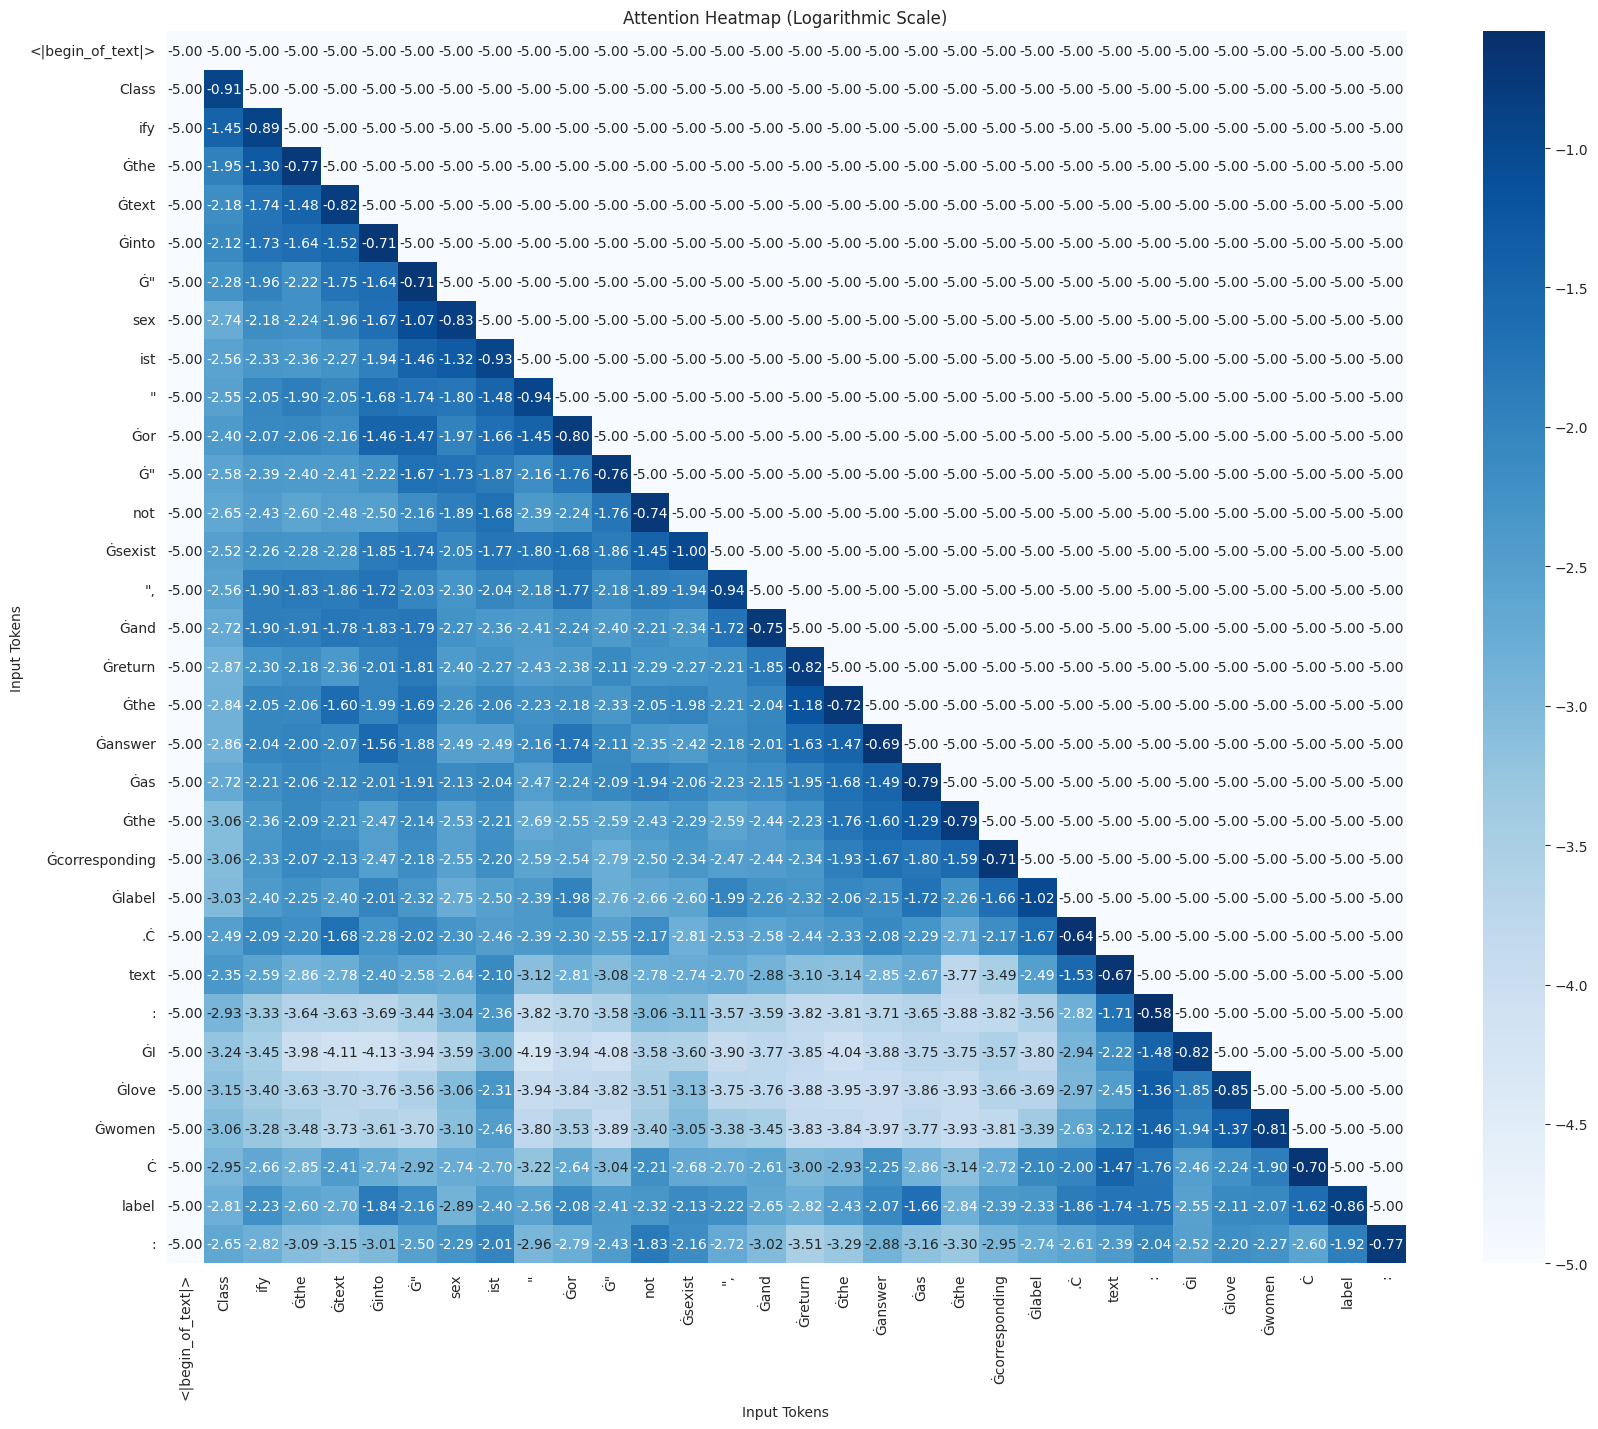

Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label: not sexist 

Next top-5 Tokens and Probabilities:
Token: ' not', Probability: 91.26%
Token: ' sexist', Probability: 8.60%
Token: ' sexy', Probability: 0.02%
Token: ' non', Probability: 0.01%
Token: ' feminist', Probability: 0.01%


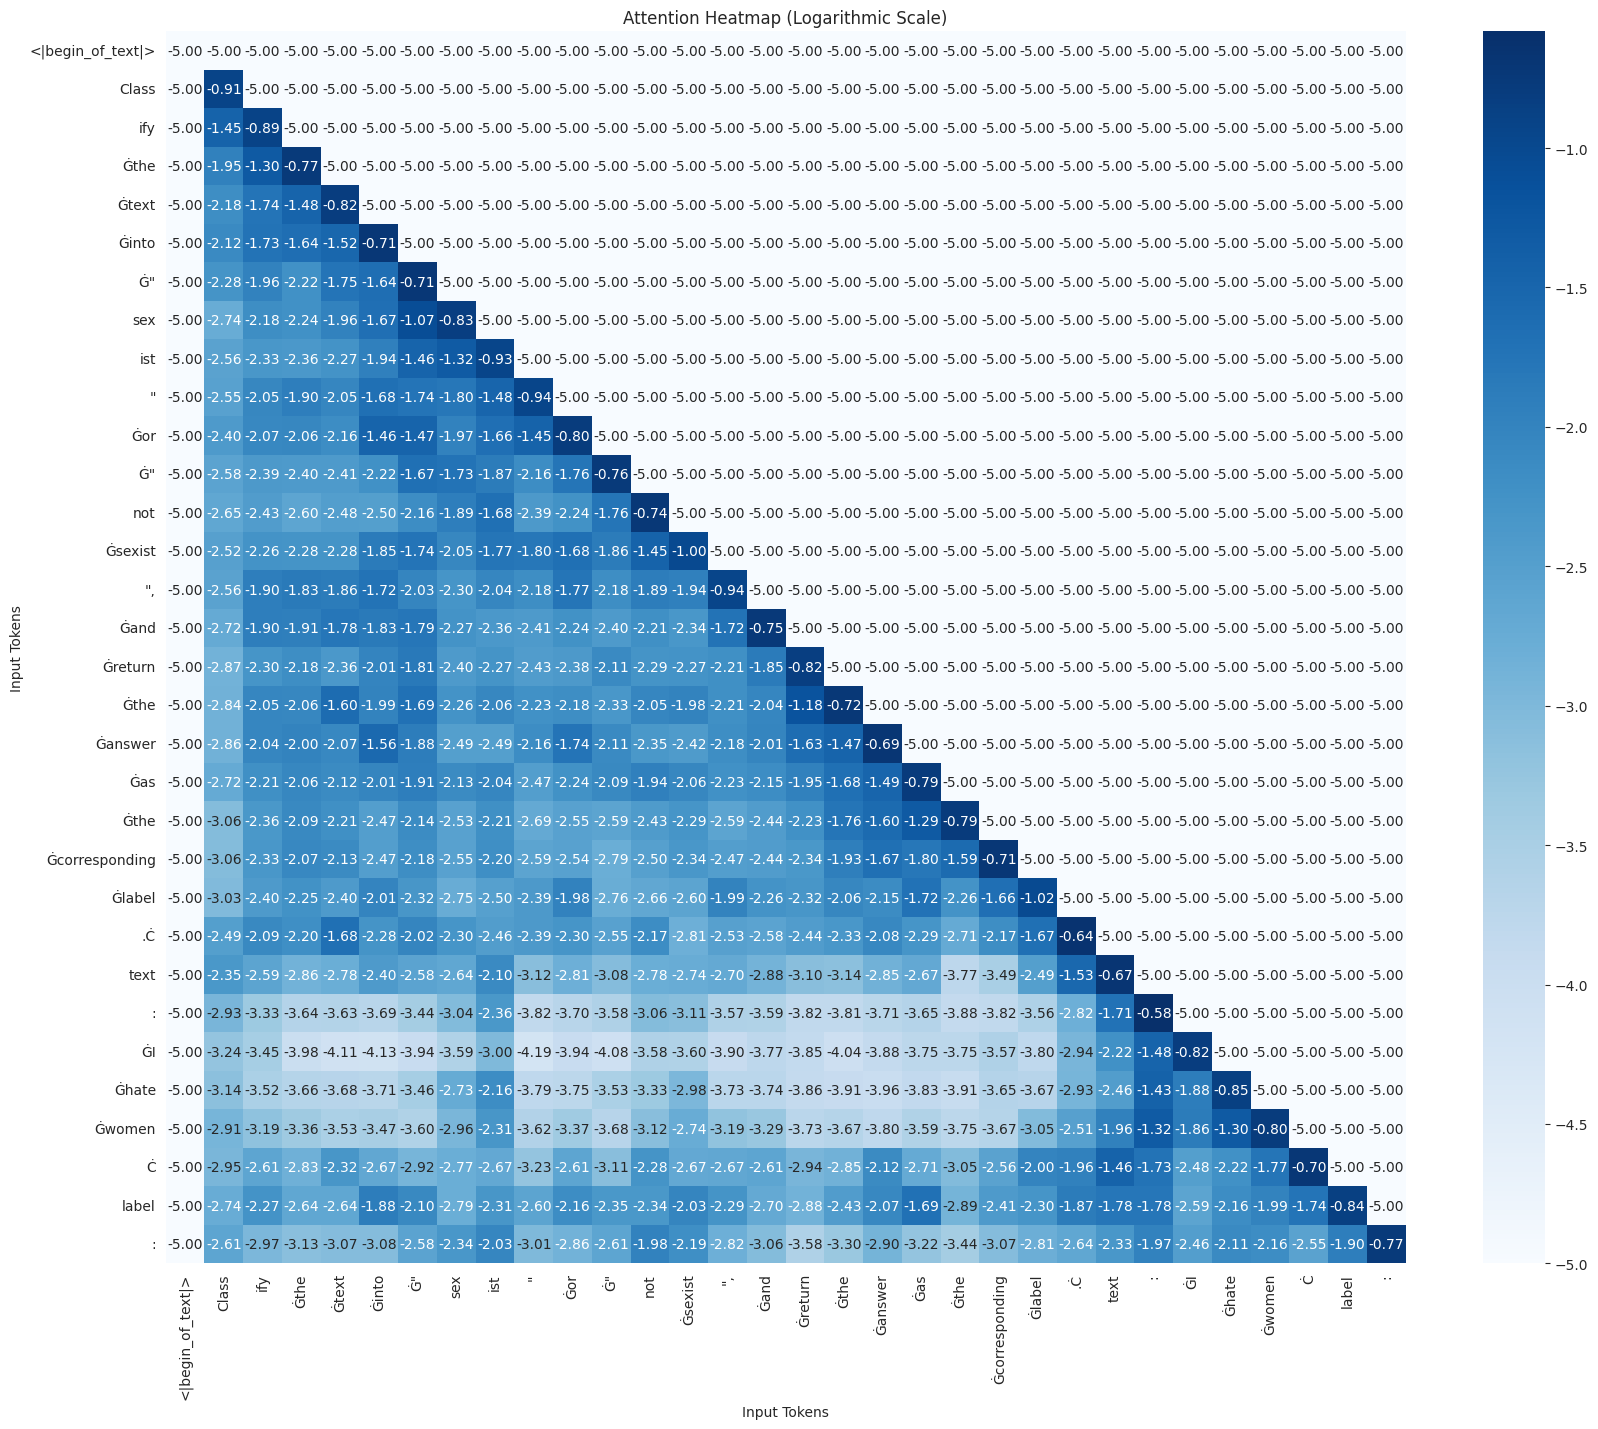

Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I hate women
label: sexist
 

Next top-5 Tokens and Probabilities:
Token: ' sexist', Probability: 96.06%
Token: ' not', Probability: 3.92%
Token: ' misogyn', Probability: 0.01%
Token: ' racist', Probability: 0.00%
Token: ' sexism', Probability: 0.00%


In [11]:
def visualize_attention_no_padding(prompt, model, tokenizer):
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=256,
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions[-1]
    attentions = attentions.squeeze(0)
    avg_attention = attentions.mean(dim=0).cpu().numpy()

    attention_mask = inputs["attention_mask"].cpu().numpy()[0]
    valid_indices = np.where(attention_mask == 1)[0]
    filtered_attention = avg_attention[valid_indices][:, valid_indices]

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][valid_indices])

    return filtered_attention, tokens


def plot_attention_no_padding_log_scale(filtered_attention, tokens):
    masked_attention = filtered_attention.copy()
    masked_attention[:, 0] = 0
    masked_attention[0, :] = 0

    log_scaled_attention = np.log10(masked_attention + 1e-5)

    plt.figure(figsize=(20, 16))
    sns.heatmap(log_scaled_attention, xticklabels=tokens, yticklabels=tokens, cmap="Blues", fmt=".2f", annot=True)
    plt.xlabel("Input Tokens")
    plt.ylabel("Input Tokens")
    plt.title("Attention Heatmap (Logarithmic Scale)")
    plt.xticks(rotation=90)
    plt.show()



prompt = generate_test_prompt({"comment": "I love women", "label": "not sexist"})

filtered_attention, tokens = visualize_attention_no_padding(prompt, model, tokenizer)
plot_attention_no_padding_log_scale(filtered_attention, tokens)
print(generate_answer(prompt, model, tokenizer), "\n")
get_next_token_probabilities(prompt, model, tokenizer)


prompt = generate_test_prompt({"comment": "I hate women", "label": "not sexist"})

filtered_attention, tokens = visualize_attention_no_padding(prompt, model, tokenizer)
plot_attention_no_padding_log_scale(filtered_attention, tokens)
print(generate_answer(prompt, model, tokenizer), "\n")
get_next_token_probabilities(prompt, model, tokenizer)

# Prompting the model to give an explanation

## Load base model, since the fine-tuned ones often just repeat the label

In [12]:
clear_memory()

model_id = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0"
)

model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
prompt = f"""
Classify the text into "sexist" or "not sexist", return the answer as the corresponding label and give an explanation.
text: I don't like women
label:
""".strip()

print(generate_answer(prompt, model, tokenizer, 100))

Classify the text into "sexist" or "not sexist", return the answer as the corresponding label and give an explanation.
text: I don't like women
label: sexist
Explanation: The text is sexist because it makes a general statement about a group of people (women) and expresses a negative sentiment towards them. This kind of language can be hurtful and perpetuate stereotypes. A more neutral or inclusive statement would be "I don't like someone who is being rude to me" or "I have a problem with someone's behavior". 

Note: The classification of sexist language can be subjective and context-dependent. However, in general, language that makes general statements


In [14]:
prompt = f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label:
""".strip()

print(f"Prompt:\n{prompt}\n")
get_next_token_probabilities(prompt, model, tokenizer)
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")

Prompt:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label:

Next top-5 Tokens and Probabilities:
Token: ' not', Probability: 39.28%
Token: ' sexist', Probability: 21.24%
Token: ' __________________', Probability: 6.41%
Token: '' \n'', Probability: 5.26%
Token: ' "', Probability: 2.73%

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label: not sexist
